In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=12, micro=4, releaselevel='final', serial=0)
matplotlib 3.9.1
numpy 1.26.4
pandas 2.2.2
sklearn 1.5.1
torch 2.3.1
cpu


## 数据准备

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms


# 定义数据集的变换
transform = transforms.Compose([
    transforms.ToTensor(), # 转换为tensor，进行归一化
    # transforms.Normalize(mean, std) # 标准化，mean和std是数据集的均值和方差
])
# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

In [7]:
type(train_ds)

torchvision.datasets.mnist.FashionMNIST

In [8]:
len(train_ds)

60000

In [9]:
type(train_ds[0])

tuple

In [10]:
# 通过id取数据，取到的是一个元祖,是第一个样本,在训练时，把特征和标签分开
img, label = train_ds[0]
img.shape
# img.shape = (1, 28, 28)，这是因为通道数在最前面

torch.Size([1, 28, 28])

In [11]:
type(img)

torch.Tensor

In [12]:
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True) #batch_size分批，shuffle洗牌
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

## 定义模型

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # 继承父类的初始化方法，子类有父类的属性
        self.flatten = nn.Flatten()  # 展平层
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 300),  # in_features=784, out_features=300, 784是输入特征数，300是输出特征数
            nn.ReLU(), # 激活函数
            nn.Linear(300, 100),#隐藏层神经元数100
            nn.ReLU(), # 激活函数
            nn.Linear(100, 10),#输出层神经元数10
        )

    def forward(self, x): # 前向计算
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 784]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits #没有经过softmax,称为logits
    
model = NeuralNetwork()

In [14]:
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [15]:
for name, param in model.named_parameters(): # 打印模型参数
      print(name, param.shape)

linear_relu_stack.0.weight torch.Size([300, 784])
linear_relu_stack.0.bias torch.Size([300])
linear_relu_stack.2.weight torch.Size([100, 300])
linear_relu_stack.2.bias torch.Size([100])
linear_relu_stack.4.weight torch.Size([10, 100])
linear_relu_stack.4.bias torch.Size([10])


In [16]:
# 看看模型参数
list(model.parameters())  # 这种方法拿到模型的所有可学习参数

[Parameter containing:
 tensor([[ 0.0197,  0.0006,  0.0162,  ..., -0.0205, -0.0255,  0.0293],
         [ 0.0275,  0.0336,  0.0139,  ..., -0.0315, -0.0285,  0.0126],
         [-0.0199,  0.0173,  0.0188,  ...,  0.0229,  0.0285, -0.0266],
         ...,
         [ 0.0072,  0.0100,  0.0067,  ..., -0.0096,  0.0285,  0.0023],
         [-0.0128, -0.0193,  0.0177,  ...,  0.0039, -0.0016,  0.0351],
         [-0.0063, -0.0140,  0.0097,  ...,  0.0176, -0.0014, -0.0168]],
        requires_grad=True),
 Parameter containing:
 tensor([ 1.7742e-02, -2.1826e-02,  1.0081e-02,  1.0526e-02, -4.8108e-03,
         -2.6885e-02, -2.9191e-02, -1.8433e-03,  5.1019e-03, -3.1129e-03,
         -5.1320e-04, -1.2647e-02,  8.5905e-03, -1.0704e-02, -1.1578e-02,
         -9.4508e-03,  1.2642e-02,  8.3997e-03, -2.1163e-02,  3.4967e-02,
          6.9250e-03, -7.4151e-03,  2.9191e-02,  2.5404e-02,  3.9256e-03,
         -1.4887e-02, -2.6723e-02, -2.0890e-02,  2.3527e-02,  2.6512e-02,
         -4.8367e-03, -1.7528e-02,  1.62

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [17]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss() #内部先做softmax，然后计算交叉熵
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package,随机梯度下降
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
from sklearn.metrics import accuracy_score

@torch.no_grad() # 装饰器，禁止反向传播，节省内存
def evaluating(model, dataloader, loss_fct):
    loss_list = [] # 记录损失
    pred_list = [] # 记录预测
    label_list = [] # 记录标签
    for datas, labels in dataloader:#10000/32=312
        datas = datas.to(device) # 转到GPU
        labels = labels.to(device) # 转到GPU
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 记录损失
        
        preds = logits.argmax(axis=-1)    # 验证集预测,argmax返回最大值索引
        pred_list.extend(preds.cpu().numpy().tolist())#将PyTorch张量转换为NumPy数组。只有当张量在CPU上时，这个转换才是合法的
        # print(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list) # 计算准确率
    return np.mean(loss_list), acc

In [22]:
# 训练
def training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=500):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar: # 进度条
        for epoch_id in range(epoch): # 训练epoch次
            # training
            for datas, labels in train_loader: #执行次数是60000/32=1875
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传，loss.backward()会计算梯度，loss对模型参数求导
                loss.backward()
                # 调整优化器，包括学习率的变动等,优化器的学习率会随着训练的进行而减小，更新w,b
                optimizer.step()

                preds = logits.argmax(axis=-1) # 训练集预测
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())   # 计算准确率，numpy可以
                loss = loss.cpu().item() # 损失转到CPU，item()取值
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                # udate step
                global_step += 1 # 全局步数加1
                pbar.update(1) # 更新进度条
                pbar.set_postfix({"epoch": epoch_id}) # 设置进度条显示信息
        
    return record_dict
        

epoch = 20
model = model.to(device)
record = training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=1000)

  0%|          | 0/37500 [00:00<?, ?it/s]

In [21]:
record

{'train': [{'loss': 2.301225423812866, 'acc': 0.125, 'step': 0},
  {'loss': 2.3100295066833496, 'acc': 0.15625, 'step': 1},
  {'loss': 2.328181266784668, 'acc': 0.09375, 'step': 2},
  {'loss': 2.3076319694519043, 'acc': 0.125, 'step': 3},
  {'loss': 2.3153111934661865, 'acc': 0.15625, 'step': 4},
  {'loss': 2.3095531463623047, 'acc': 0.15625, 'step': 5},
  {'loss': 2.3130083084106445, 'acc': 0.21875, 'step': 6},
  {'loss': 2.340308427810669, 'acc': 0.125, 'step': 7},
  {'loss': 2.3100228309631348, 'acc': 0.125, 'step': 8},
  {'loss': 2.3105368614196777, 'acc': 0.125, 'step': 9},
  {'loss': 2.32228422164917, 'acc': 0.125, 'step': 10},
  {'loss': 2.3030176162719727, 'acc': 0.125, 'step': 11},
  {'loss': 2.294104814529419, 'acc': 0.15625, 'step': 12},
  {'loss': 2.3012332916259766, 'acc': 0.09375, 'step': 13},
  {'loss': 2.2904341220855713, 'acc': 0.1875, 'step': 14},
  {'loss': 2.2926840782165527, 'acc': 0.15625, 'step': 15},
  {'loss': 2.312147378921509, 'acc': 0.0625, 'step': 16},
  {'

[0.52730244 0.29458266 0.31725857 0.17697258 0.15025264 0.13579831
 0.1222149  0.4638699  0.23732525 0.12844822 0.14631955 0.09055643
 0.44315901 0.28359282 0.32615855 0.32395151 0.12117932 0.19881688
 0.19757445 0.34075385 0.44449088 0.36794207 0.60318559 0.10318457
 0.21850184 0.2708905  0.25812802 0.34405741 0.18339093 0.4152942
 0.17674185 0.16487244 0.11257061 0.27371529 0.1898526  0.07945539
 0.17534022 0.23091359]
[0.75    0.875   0.90625 0.96875 0.96875 0.96875 0.96875 0.84375 0.90625
 0.96875 0.96875 1.      0.8125  0.90625 0.84375 0.8125  0.96875 0.90625
 0.90625 0.875   0.8125  0.8125  0.78125 0.96875 0.90625 0.90625 0.9375
 0.875   0.9375  0.8125  0.90625 0.9375  0.96875 0.90625 0.96875 1.
 0.9375  0.90625]


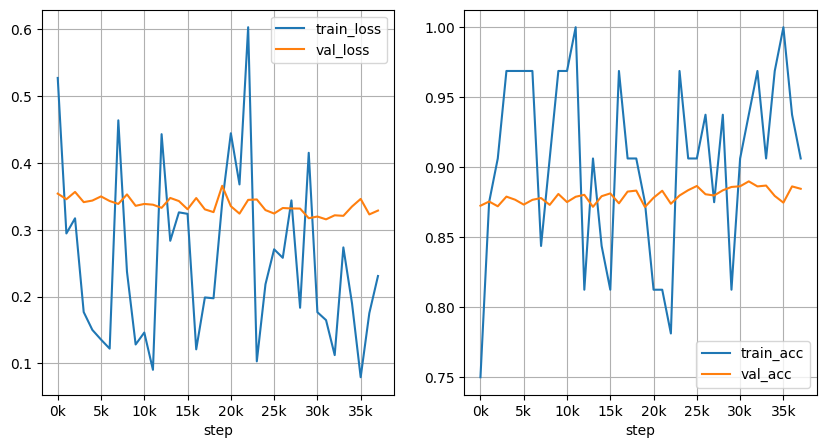

In [24]:

#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=1000):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    last_step = train_df.index[-1]

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        print(train_df[item].values)
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        axs[idx].set_xticklabels(map(lambda x: f"{int(x / 1000)}k", range(0, last_step, 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record)  #横坐标是 steps